In [821]:
## import all necessary libraries ##

import numpy as np
from datetime import datetime

#########################

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter

#########################

import distance

from similarity.levenshtein import Levenshtein
levenshtein = Levenshtein()

from similarity.damerau import Damerau
damerau = Damerau()

from pyjarowinkler import distance as jwdistance
from similarity.jarowinkler import JaroWinkler
jarowinkler = JaroWinkler()

from similarity.weighted_levenshtein import WeightedLevenshtein
from similarity.weighted_levenshtein import CharacterSubstitutionInterface
import math
class CharacterSubstitution(CharacterSubstitutionInterface):
    def cost(self, c0, c1):
        return math.inf # assign inifte weight to all substitutions
levenshtein2 = WeightedLevenshtein(CharacterSubstitution())

#########################


# Distance class

In [ ]:
class Distance:
    
    ### SETUP ###
    
    ## load dataset, generate mapping and generate strings
    def __init__(self, path):
        self.strings = []
        self.matrix = []
        self.transl = {}
        self.variant_to_Vindex = {}
        self.index_to_variant = []
        
        self.log = xes_importer.apply(path) # adjust for local file location       
        
        self.gen_trace_to_Tindex()
        
        self.gen_mapping()
        self.gen_variant_strings()
    
    ## generate mapping from activity to char
    def gen_mapping(self):
        ## generate mapping from activities to chars ##
        # TODO read Activity classifier for correct naming of activities
        activities = list(attributes_filter.get_attribute_values(self.log, "concept:name").keys())
        #activities2 = list(attributes_filter.get_attribute_values(self.log, "lifecycle:transition").keys())
        #activities = [i + "-" + j for i, j in zip(activities2, activities2)]
        for i, a in enumerate(activities):
            self.transl[a] = chr(i+1)

    def gen_trace_to_Tindex(self):
        self.trace_to_Tindex = {}
        for i, t in enumerate(self.log):
            self.trace_to_Tindex[t] = i
            
            
    ## generate strings for all variants
    def gen_variant_strings(self):
        self.variants = variants_filter.get_variants(self.log) # all variants as dictionary
        variant_strings = list(self.variants.keys()) # variants as strings
        self.variant_to_index = {} # dictionary to translate variant to index in list for later lookup of traces
        
        for i, v in enumerate(variant_strings):
            string = ""
            for e in v.split(","):
                string = string + self.transl[e] 
            
            #self.strings.append(list_to_string(v.split(",")))
            self.strings.append(string)
            
            self.variant_to_index[v] = i
            self.index_to_variant.append(v)
            
        print("Number of strings: " + str(len(self.strings)))
    
    ### CALCULATION ###
    
    ## calculate distance matrix
    def calculate(self):
        n = len(self.strings)
        self.matrix = np.full((n, n), 0, dtype = np.uint8)

        for i, x in enumerate(self.strings):
            for j, y in enumerate(self.strings):
                if j >= i: # only calculate upper right triangle of matrix
                    #dist = distance.hamming(x, y)
                    dist = levenshtein.distance(x, y)
                    #dist = levenshtein2.distance(x, y)
                    #dist = damerau.distance(x, y)
                    #dist = (1- jarowinkler.similarity(x, y))*255
                    #print(dist)
                    self.matrix[i][j] = dist

        # mirror upper right triangle of matrix by adding the transposition
        self.matrix = self.matrix + self.matrix.T

        return self.matrix
    
    ### RETRIEVAL ###
    
    ## translate trace to its corresponding matrix index
    def trace_to_index(self, trace):
        # convert trace to string tion of variant (concept:name separated by commas)
        trace_string = ""
        for e in trace:
            trace_string = trace_string + e["concept:name"] + ","
        trace_string = trace_string[:-1] # remove last comma

        return self.variant_to_index[trace_string]
    
    ## translate matrix (variant) index to trace indices
    def index_to_traces(self, i):
        variant_string = self.index_to_variant[i]
        traces = self.variants[variant_string] # retrieve traces from variant dictionary
        filtered_variants = {variant_string: traces} # generate new variants dictionary with only one variant
        
        filtered_log = variants_filter.apply(self.log, filtered_variants)
        traces = []
        for t in filtered_log:
            traces.append(t)
        
        return traces
        
    
    ## retrieve distance of two traces from matrix
    def dist(self, t1, t2):
        i1 = self.trace_to_index(t1)
        i2 = self.trace_to_index(t2)
        return self.matrix[i1][i2]
    
    # return traces of k nearest neighbors of A
    def N_k(self, k, A):
        A_variant_index = self.trace_to_index(A)
        res_dict = {} # result cache
        if A_variant_index in res_dict.keys(): # check result cache
            print("N_k cache hit")
            return res_dict(A_variant_index)
        else:
            idx_sort = np.argsort(self.matrix[A_variant_index]) # indices of neighbors in ascending distance

            i = 0
            N_k_traces = []
            while len(N_k_traces) < k:
                N_k_traces.extend(self.index_to_traces(idx_sort[i]))
                if A in N_k_traces:
                    N_k_traces.remove(A)
                i = i + 1
            
            res_dict[A_variant_index] = N_k_traces
            return N_k_traces

# LOF class

In [914]:
class LOF:
    def __init__(self, path):
        self.dist = Distance(path)
        self.dist.calculate()
        
    ## k-distance
    def k_distance(self, k, A):
        res_dict = {} # result cache
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in res_dict.keys(): # check result cache
            print("k_distance cache hit")
            return res_dict(A_variant_index)
        else:
            N_k = self.dist.N_k(k, A)
            k_variant_index = self.dist.trace_to_index(N_k[-1])
            A_variant_index = self.dist.trace_to_index(A)

            res = self.dist.matrix[A_variant_index][k_variant_index] # retrieve distance from k-th nearest neighbor (-1 to offset arraystart, +1 to not include trace itself)
            res_dict[A_variant_index] = res
            return res
        
    ## reachability distance
    def reachability_dist(self, k, A, B):
        res_dict = {} # result cache
        A_variant_index = self.dist.trace_to_index(A)
        B_variant_index = self.dist.trace_to_index(B)
        if (A_variant_index, B_variant_index) in res_dict.keys(): # check result cache
            print("rd cache hit")
            return res_dict(A_variant_index)
        else:
            res = max(self.k_distance(k, B), self.dist.matrix[A_variant_index][B_variant_index])
            res_dict[(A_variant_index, B_variant_index)] = res
            return res
    
    ## local reachability density
    def lrd(self, k, A):
        res_dict = {} # result cache
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in res_dict.keys(): # check result cache
            print("lrd cache hit")
            return res_dict(A_variant_index)
        else:
            
            N_k = self.dist.N_k(k, A)            
            sum = 0
            for b in N_k:
                   sum = sum + self.reachability_dist(k, A, b) # sum of rachability distances in k-Neighborhood
            
            res = 1 / (sum / len(N_k))
            res_dict[A_variant_index] = res
            return res
        
    def lof(self, k, A):
        res_dict = {} # result cache
        A_variant_index = self.dist.trace_to_index(A)
        if A_variant_index in res_dict.keys(): # check result cache
            print("lof cache hit")
            return res_dict(A_variant_index)
        else:
            
            N_k = self.dist.N_k(k, A)
            sum = 0
            for b in N_k:
                sum = sum + self.lrd(k, b)

            res = sum / (len(N_k) * self.lrd(k, A))
            res_dict[A_variant_index] = res
            return res
    
    def calculate(self, k):
        res = np.array([])
        for a in self.dist.log:
            res = np.append(res, self.lof(k, a))
            
        return res
    

# Run

In [915]:
path = "Datasets/BPIC13.xes"
lof = LOF(path)

parsing log, completed traces ::   0%|          | 0/1487 [00:00<?, ?it/s]

Number of strings: 183


In [923]:
start = datetime.now()
print(start)

print(lof.lof(56, lof.dist.log[0]))
print(datetime.now())
print(lof.lof(56, lof.dist.log[1]))
print(datetime.now())
print(lof.lof(56, lof.dist.log[1]))

end = datetime.now()
print(end-start)

2021-03-04 23:34:47.343972
0.9960258320914057
2021-03-04 23:35:53.005022


<ipython-input-914-7917359a8bc6>:49: RuntimeWarning: divide by zero encountered in double_scalars
  res = 1 / (sum / len(N_k))


inf
2021-03-04 23:38:01.832801
inf
0:05:43.331763


In [904]:
len(lof.dist.N_k(56, lof.dist.log[0]))

61

In [921]:
str(later - now)

'0:00:06.328357'

In [593]:
lofs_argsort = np.argsort(lofs)

for i in lofs_argsort:
    print(str(round(lofs[i], 3)) + " \t " + lof.dist.index_to_variant[i])

0.886 	 Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit FINAL_APPROVED by SUPERVISOR,Start trip,End trip,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled
0.888 	 Start trip,End trip,Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit APPROVED by BUDGET OWNER,Permit FINAL_APPROVED by SUPERVISOR,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled
0.895 	 Permit SUBMITTED by EMPLOYEE,Permit FINAL_APPROVED by SUPERVISOR,Start trip,End trip,Declaration SUBMITTED by EMPLOYEE,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled
0.899 	 Permit SUBMITTED by EMPLOYEE,Permit APPROVED by ADMINISTRATION,Permit FINAL_APPROVED by SUPERVISOR,Declaration SAVED by EMPLOYEE,Start tri

In [594]:
import matplotlib.pyplot as plt

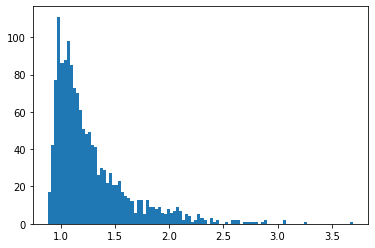

In [599]:
plt.hist(lofs, 100)
plt.show()

In [ ]:
%reset